**Author:** Andy Tzanidakis, Neven Caplar and the LINCC team \
**Last updated**: October 25, 2024

## Overview

In this notebook we will learn how to:

- Query and filter catalog data
- Compute time-series features for LSDB catalogs using `nested-dask`
- Plot light curves and periodograms

In [19]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hats.inspection import plot_pixels
from hats.io.file_io import read_parquet_metadata

# Astropy
from astropy.timeseries import LombScargle

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.4.1


/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [2]:
catalogs_dir = "https://data.lsdb.io/hats"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"
gaia_margin_path = f"{catalogs_dir}/gaia_dr3/gaia_10arcs"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf_dr14/ztf_object"
ztf_source_path = f"{catalogs_dir}/ztf_dr14/ztf_source"
ztf_object_margin_path = f"{catalogs_dir}/ztf_dr14/ztf_object_10arcs"

## Initialize Dask Client

Before we start building our workflow, let's initialize our Dask Client. The machine we're using has 8 cores and 25GiB of RAM so we'll decide to make good use of resources and go with 4 workers, each with 6 GiB of memory and 1 thread.

In [3]:
from dask.distributed import Client
client = Client(n_workers=4, memory_limit="6GiB", threads_per_worker=1)

/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32882 instead
  warnings.warn(


## Get Gaia and ZTF

Let's read Gaia and ZTF (both lazily) as demonstrated in the first notebook.

In [4]:
%%time

# Load Gaia object table (with margins!)
gaia = lsdb.read_hats(gaia_path, columns=['ra', 'dec', 'parallax'], margin_cache=gaia_margin_path)

# Define a cone region of interest for ZTF
cone_search = ConeSearch(ra=132.8460000, dec=+11.8140000, radius_arcsec=5_000)

# Load ZTF object table
ztf = lsdb.read_hats(ztf_object_path, columns=['ra', 'dec', 'ps1_objid'], search_filter=cone_search)

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hats(ztf_source_path, columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], search_filter=cone_search)

CPU times: user 2.53 s, sys: 383 ms, total: 2.92 s
Wall time: 2.85 s


## Create a sample object catalog

To create our sample let's crossmatch our ZTF region with Gaia with a 3-arcsecond radius.

In [5]:
_sample = ztf.crossmatch(gaia, radius_arcsec=3)

We can have a look at the object matches because this sample is relatively small and it fits in memory! 

In [6]:
%%time
_sample_computed = _sample.compute()
_sample_computed

CPU times: user 633 ms, sys: 224 ms, total: 857 ms
Wall time: 5.21 s


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_healpix_29,,,,,,,
298908806134124139,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933
298908810706785769,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202
298908811338617360,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445
298920356055544103,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692
298920365329078665,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189
...,...,...,...,...,...,...,...
304104164045541160,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713
304105129564083317,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951
304105132512712531,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055


In [7]:
print (f"Number of objects in crossmatch: {len(_sample_computed)}")

Number of objects in crossmatch: 36717


We selected a very small region of the sky - 5000 arcsec - and, as a result, our objects are contained in just a handful of pixels. In the following mollview of the pixel map, the gray color means that our sample catalog does not have coverage for that region in space.

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Sample catalog pixel map'}>)

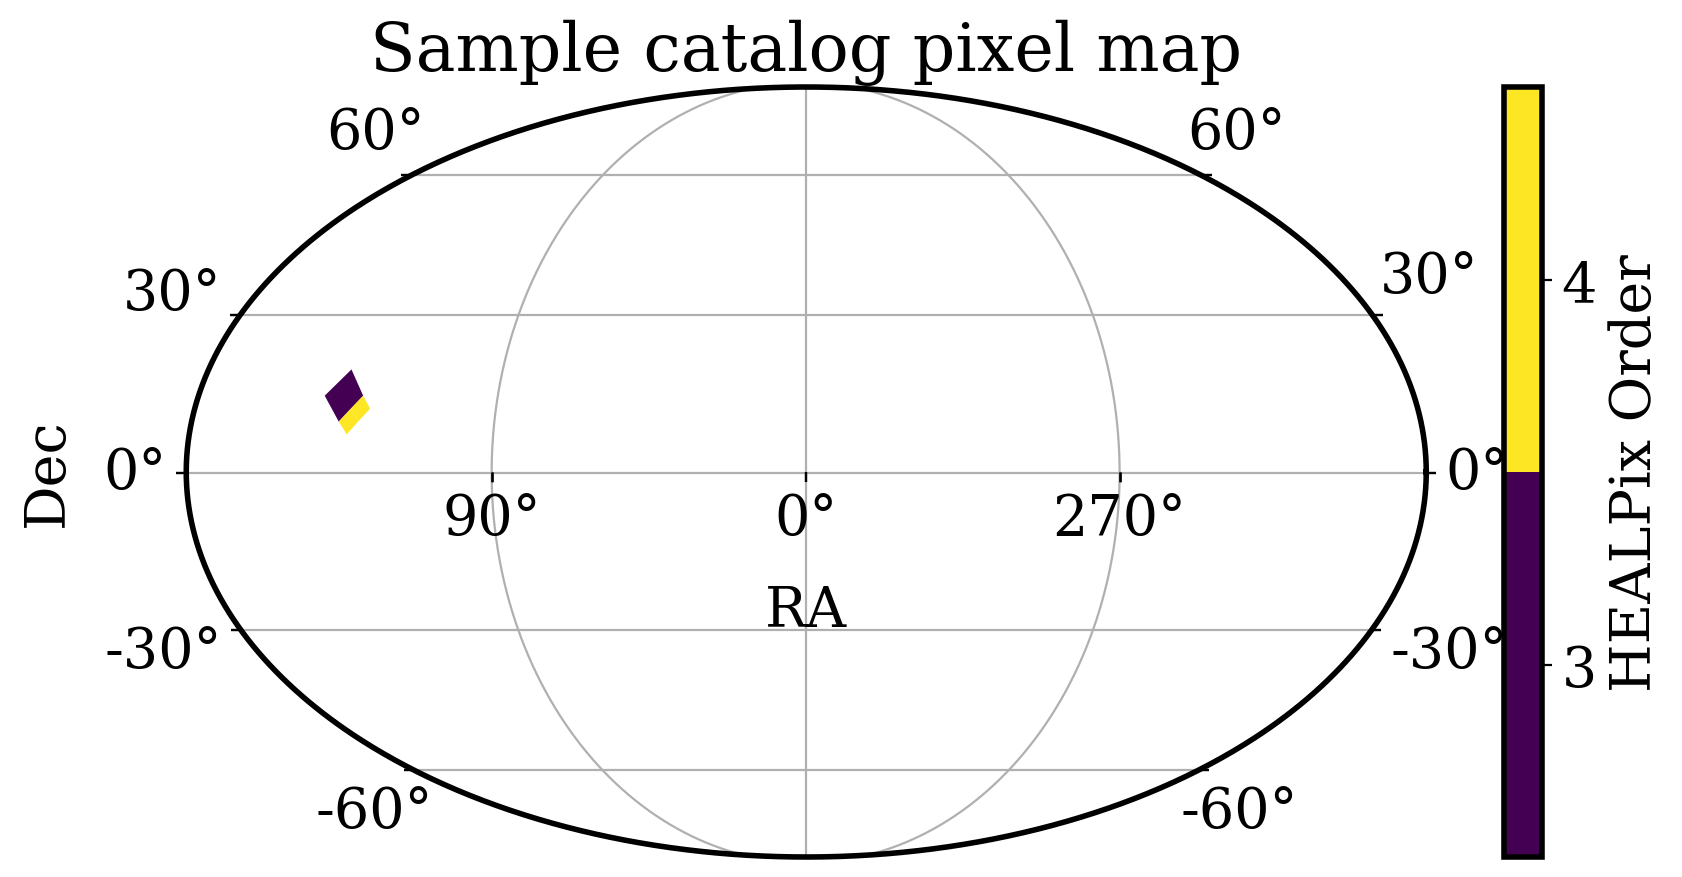

In [8]:
_sample.plot_pixels(plot_title="Sample catalog pixel map")

## Fetch ZTF light curves for the samples

We will now perform a join operation between our sample objects and their respective ZTF sources. We will use the PanSTARRS object ID, as this is the index that both catalogs share. This is where `nested-dask` features come in handy. Under the hood, this `join_nested` call packs the time-domain data of each object as an additional column, which we decided to conveniently named `sources`.

In [9]:
_sources = _sample.join_nested(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid", nested_column_name="sources")
_sources = _sources._ddf # remove once have added LSDB wrappers for nested_dask
# TODO: here, remove duplicates, with map_paritions; should be a method in dataframe that does it
_sources

/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources
npartitions=6,,,,,,,,
298644950290006016,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
299207900243427328,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
303992974847508480,...,...,...,...,...,...,...,...
304274449824219136,...,...,...,...,...,...,...,...


Note that we also get a warning stating that we are not using a margin catalog, as previously discussed in the first notebook.

## Filter on r-band

Our workflow will only operate on r-band data. We can apply the necessary cuts to our data to make sure that only light curves that have at least 10 observations in r-band will be considered!

In [10]:
# Query for observations in r-band
r_band = _sources.query("sources.band == 'r'")
# Calculate the number of observations
nobs = r_band.reduce(np.size, "sources.mjd", meta={0: int}).rename(columns={0: "nobs"})
# Get only those light curves with at least 10 observations
r_band = r_band[nobs["nobs"] > 10]

In [11]:
r_band

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources
npartitions=6,,,,,,,,
298644950290006016,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
299207900243427328,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
303992974847508480,...,...,...,...,...,...,...,...
304274449824219136,...,...,...,...,...,...,...,...


In [12]:
%%time
r_band.compute()

2024-11-05 11:06:21,414 - distributed.worker - ERROR - Compute Failed
Key:       ('nestedframe-fused-getitem-f2b0428fe3e96901505a7e6b51058cca', 1)
State:     executing
Function:  execute_task
args:      ((<function Fused._execute_task at 0x7f6758585300>, {'nestedframe-fused-getitem-f2b0428fe3e96901505a7e6b51058cca': ('getitem-d06d864f78c99d74d5a97b7478905bd6', 1), ('getitem-d06d864f78c99d74d5a97b7478905bd6', 1): (<built-in function getitem>, ('lambda-7267ea0f5eba3388d10a1132aa4440c0', 1), ('gt-1fd2250326907849ac9847633b625443', 1)), ('gt-1fd2250326907849ac9847633b625443', 1): (<built-in function gt>, ('getitem-45429af8ec53d59564190bff91f106bd', 1), 10), ('getitem-45429af8ec53d59564190bff91f106bd', 1): (<built-in function getitem>, ('operation-5640cc66d36f3c21c4eb1dd3ac3891b6', 1), 'nobs'), ('operation-5640cc66d36f3c21c4eb1dd3ac3891b6', 1): (<function RenameFrame.operation at 0x7f675856cc20>, ('lambda-50baa81ca0b3ea741d4564a9e220432e', 1), {0: 'nobs'}), ('lambda-50baa81ca0b3ea741d4564a9

ValueError: The index of the input dataframe must be sorted

## Extract features from light curves

We will now write custom analysis functions to compute features (statistics) on each light curve. Some of these timeseries features (e.g. inverse Von Neumann, normalized excess variance) characterize the amount of outliers in the timeseries. They have been heavily used in literature, for example, to find variable stars.

In [13]:
# Column names for the custom features
cols = ['period', 'power', 'snr', 'mean', 'invNeumann', 'NormExcessVar', 'Nphot']

In [14]:
def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """Computes an optimized periodogram frequency grid for a given time series. 

    Parameters:
    ----------
    x0 (array-like): The input time axis.
    oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    ----------
    array: The computed optimized periodogram frequency grid.
    """

    num_points = len(x0)
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """Calculate the time-weighted inverse Von Neumann statistic.

    Parameters:
    ----------
    t (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    wstd (float): The weighted standard deviation of the magnitude.

    Returns:
    ----------
    float: The time-weighted inverse Von Neumann stat.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """Calculate the normalized excess variance statistic.

    Parameters:
    ----------
    mag (array-like): The input magnitude axis.
    err (array-like): The input magnitude error axis.
    N (int): The number of data points.
    wmean (float): The weighted mean of the magnitude.

    Returns:
    ----------
    float: The normalized excess variance statistic.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

def calc_features(time, mag, magerr, flag, band, custom_cols=cols):
    """Custom time-series features calculator.
    
    Parameters:
    ----------
    time (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    magerr (array-like): The input magnitude error axis.
    flag (array-like): The input flag axis.
    band (array-like): The input band axis.

    Returns:
    ----------
    pd.Series: The computed custom time-series features.
    """
    # Quality flags
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)
    
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                          normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power) # significance of periodogram, see Coughlin et al. 2021 (eqn. 2)

        # Other featues to compute 
        Neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        ExcVar = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        Nphot = len(time_)

        return pd.Series([period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag_), Neu, ExcVar, Nphot],
                            index=custom_cols)  
    else:
        return pd.Series(np.zeros(len(custom_cols)), index=custom_cols)

We can now apply the feature calculator function `calc_features` to each light curve.

In [15]:
features = r_band.reduce(
    calc_features,
    "sources.mjd",
    "sources.mag",
    "sources.magerr",
    "sources.catflags",
    "sources.band",
    meta={name: float for name in cols},
)
features

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
npartitions=6,,,,,,,
298644950290006016,float64,float64,float64,float64,float64,float64,float64
299207900243427328,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
303992974847508480,...,...,...,...,...,...,...
304274449824219136,...,...,...,...,...,...,...


Let's compute the result (bring it into memory). This will take a few minutes and display some expected runtime warnings.

In [16]:
%%time
features = features.compute()

2024-11-05 11:06:38,537 - distributed.worker - ERROR - Compute Failed
Key:       ('nestedframe-fused-lambda-8a7ff9ad69007232517ecb97c6a600b4', 5)
State:     executing
Function:  execute_task
args:      ((<function Fused._execute_task at 0x7f8234416200>, {'nestedframe-fused-lambda-8a7ff9ad69007232517ecb97c6a600b4': ('lambda-d59c9f4ed246361524d0645dcb146711', 5), ('lambda-d59c9f4ed246361524d0645dcb146711', 5): (<function apply at 0x7f825689f100>, <function apply_and_enforce at 0x7f8234749e40>, [('getitem-d06d864f78c99d74d5a97b7478905bd6', 5)], {'_func': <function NestedFrame.reduce.<locals>.<lambda> at 0x7f81e99d5940>, '_meta': Empty DataFrame
Columns: [period, power, snr, mean, invNeumann, NormExcessVar, Nphot]
Index: []}), ('getitem-d06d864f78c99d74d5a97b7478905bd6', 5): (<built-in function getitem>, ('lambda-7267ea0f5eba3388d10a1132aa4440c0', 5), ('gt-1fd2250326907849ac9847633b625443', 5)), ('gt-1fd2250326907849ac9847633b625443', 5): (<built-in function gt>, ('getitem-45429af8ec53d595

ValueError: The index of the input dataframe must be sorted

Let's inspect the results table and make some plots of our time series features.

In [17]:
# We have the results!
features

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
npartitions=6,,,,,,,
298644950290006016,float64,float64,float64,float64,float64,float64,float64
299207900243427328,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
303992974847508480,...,...,...,...,...,...,...
304274449824219136,...,...,...,...,...,...,...


In this figure we demonstrate the periods corresponding to highest power in the Lomb Scargle periodogram. Immediately, we can see a few overdensities of period, that are likely originating from the ZTF aliasing sampling cadence. Between those aliasing periods, those with high SNR score are possible periodic candidates that will require further investigation.

Task exception was never retrieved
future: <Task finished name='Task-21317' coro=<Client._gather.<locals>.wait() done, defined at /astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit


2024-11-05 11:07:03,761 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('read_pixel-_to_string_dtype-nestedframe-search_points-c0f71e45ca5f85f85f8f18733655ef32', 0))" coro=<Worker.execute() done, defined at /astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/distributed/worker_state_machine.py:3609>> ended with CancelledError


KeyboardInterrupt: 

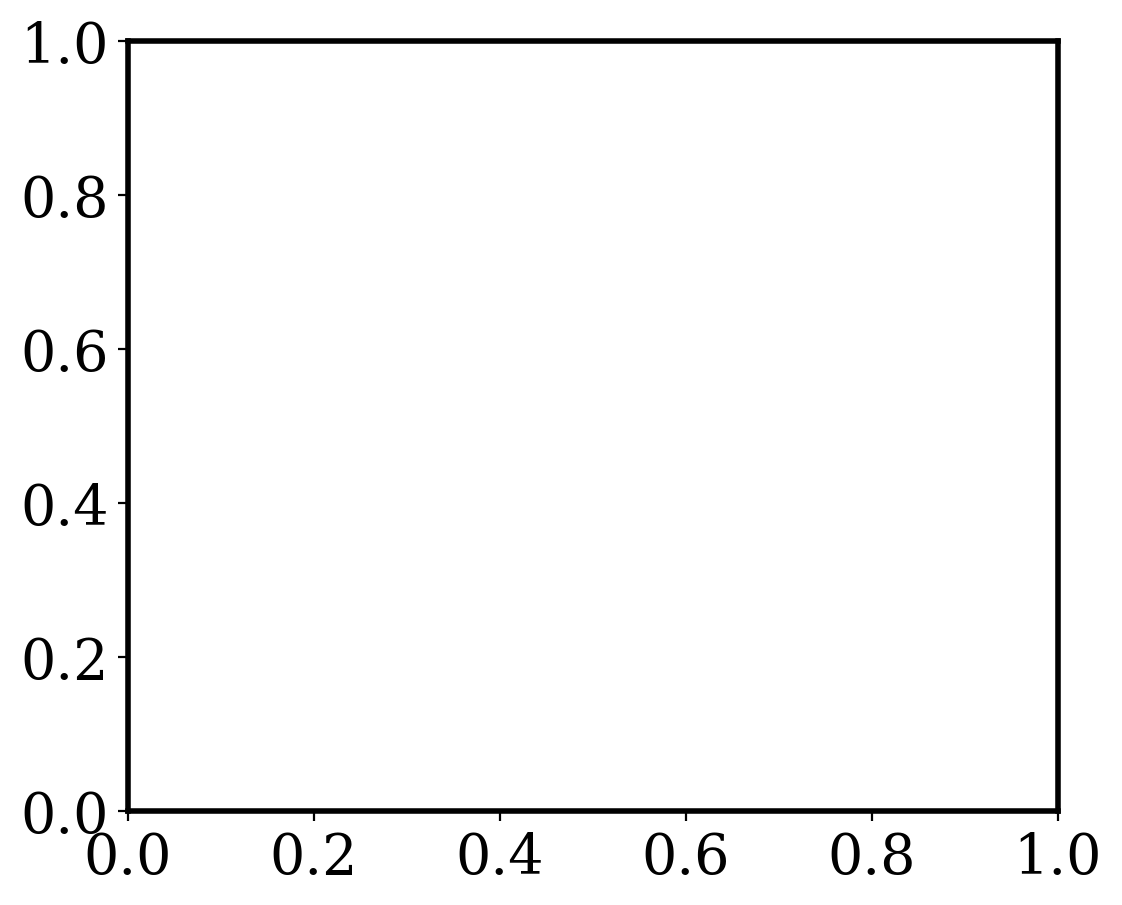

2024-11-05 11:07:05,766 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/asyncio/base_events.py", line 687, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/distributed/nanny.py", line 984, in run
    await worker.finished()
  File "/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/distributed/core.py", line 491, in finished
    await self._event_finished.wait()
  File "/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/asyncio/locks.py", line 212, in wait
    await fut
asyncio.exceptions.CancelledE

In [18]:
plt.figure(figsize=(6,5))
plt.scatter(features['period'], features['power'], s=0.1, c=np.log(features['snr']), cmap='magma', vmin=1, vmax=3)
plt.colorbar(label='log(SNR)')
plt.ylim(1e-2, 1e0)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.minorticks_on()

Below is the ZTF periodogram where also observe the aliasing sampling periods. For more information about periodograms please have a look at the [references](#References) section of this notebook.

![ZTF periodogram](https://raw.githubusercontent.com/lincc-frameworks/MWGaia-DN_Introductory_School/main/assets/ztf-periodogram.jpg)

## Plot light curve

We can now find a ZTF object with a high period SNR and that is bright, and plot the ZTF-r band light curve.

In [ ]:
# Select good SNR candidate
features[(features['snr']>20) & (features['mean']<15)].head(5)

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_hipscat_index,,,,,,,
1209433013427896320,0.217326,0.716238,22.941490,14.440848,32.595191,19957.636088,613.0
1209943734423126016,0.996238,0.352265,20.733923,14.714997,2.917700,276017.138205,660.0
1215978709064876032,0.787238,0.397726,24.705761,14.533778,2.560923,217372.218784,1137.0
1215995140963827712,0.499223,0.169420,22.203818,12.941055,1.087141,804302.105806,617.0
1216238507677188096,0.996239,0.098632,21.619643,14.316386,0.712379,941602.836716,1145.0


In [ ]:
# Select a light curve with high SNR
object_id = 1209433013427896320 # hips index
best_period = 0.217326 # (in days) best period from the above table

In [ ]:
# Compute the light curve magnitudes
lc_object = r_band.loc[object_id].query("sources.band == 'r'")
lc = lc_object.sources.compute().iloc[0]

When we fold the light curve on the correct period the scatter between the points is minimized, and therefore, the observations line up.

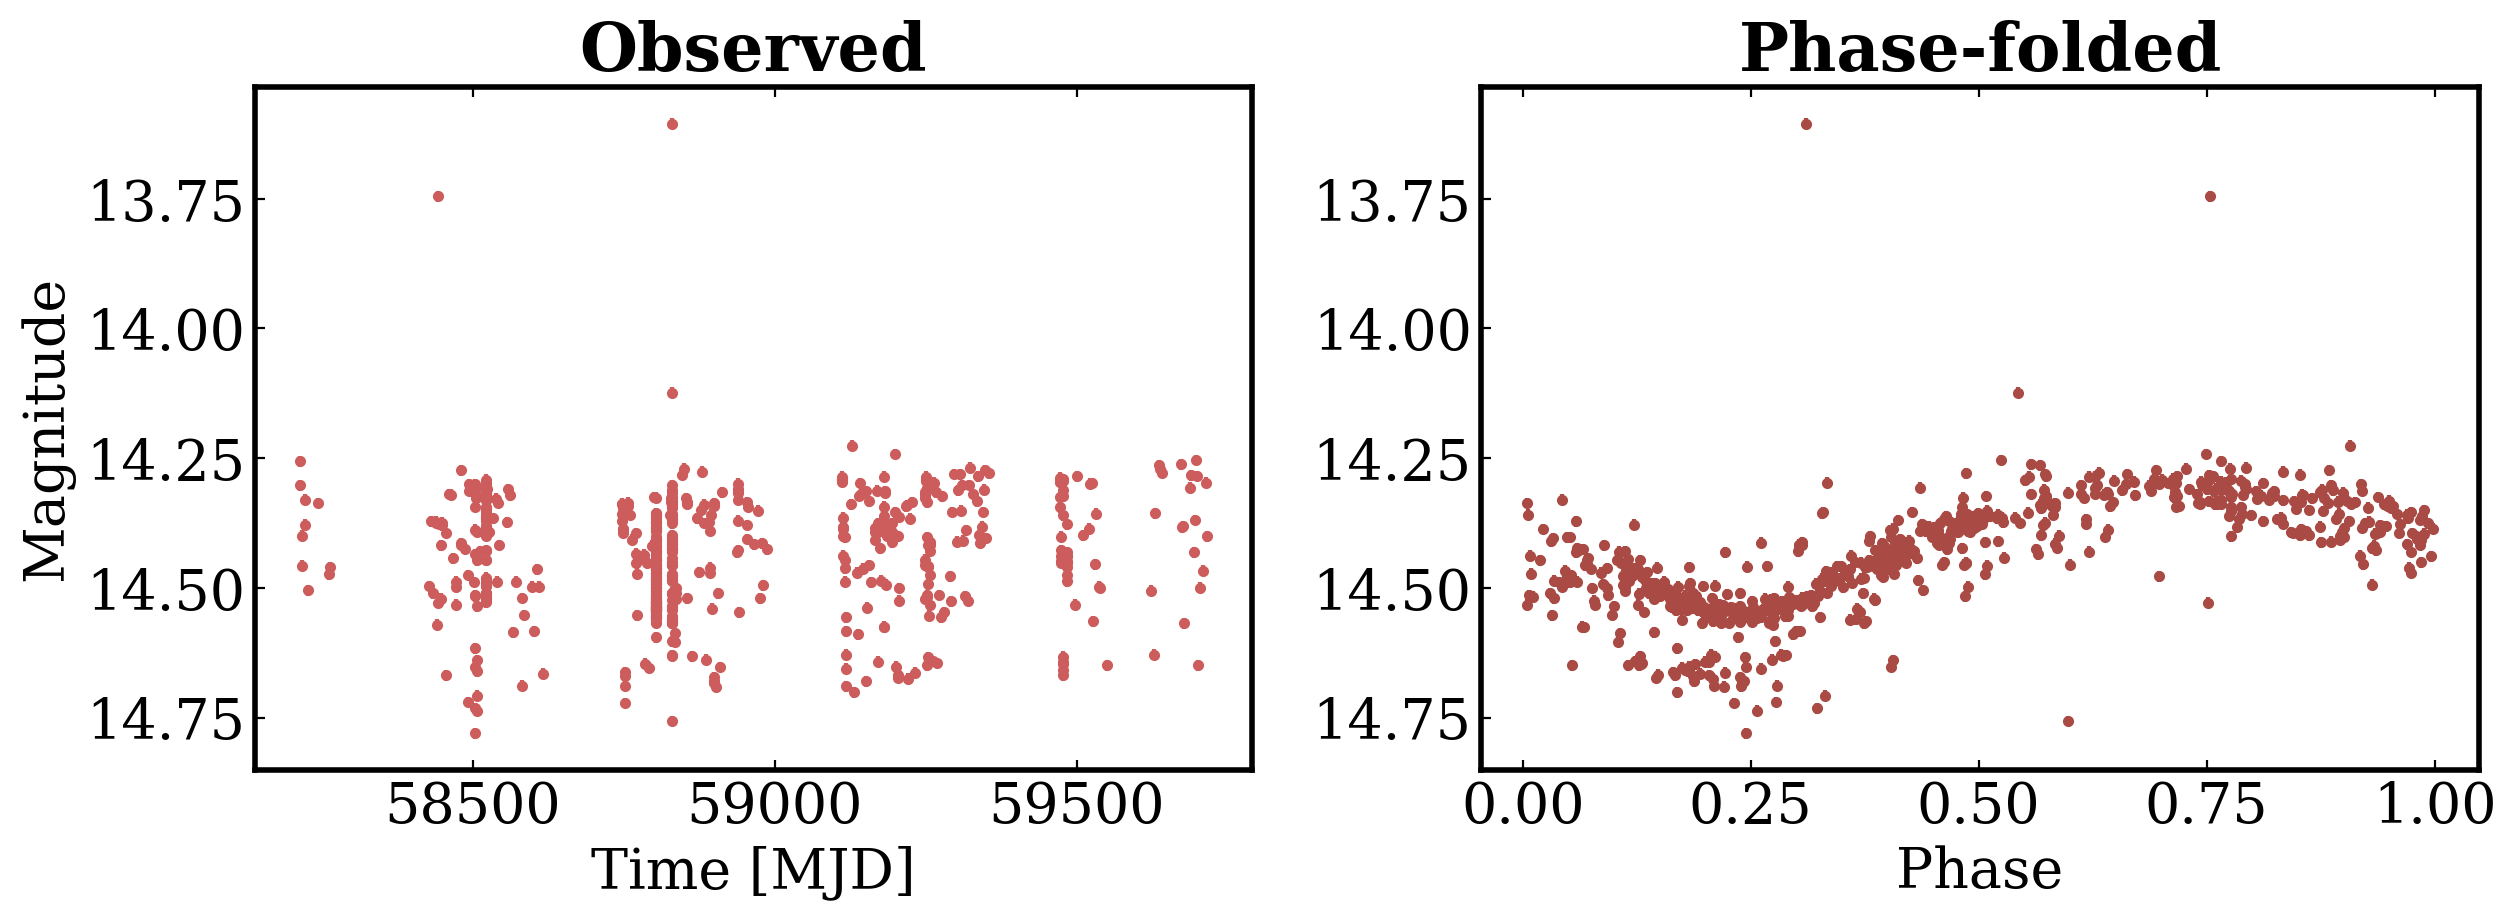

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].errorbar(
    lc["mjd"],
    lc["mag"],
    yerr=lc["magerr"], 
    fmt='.',
    color='indianred'
)

ax[1].errorbar((lc["mjd"].to_numpy()%best_period)/best_period, lc["mag"],
                yerr=lc["magerr"], fmt='.', color='#AA4A44')
ax[1].set_xlabel('Phase')
ax[0].set_xlabel('Time [MJD]')
ax[1].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[1].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].set_ylabel('Magnitude')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Observed", weight='bold')
ax[1].set_title("Phase-folded", weight='bold')

plt.tight_layout()

## Extra topics

### Existing feature extractors

In this notebook we demonstrated how you can define and use your own custom functions to operate on light curves. There are also third-party packages that extract common features so that you don't have to implement these operations yourself (e.g. [`light-curve`](https://github.com/light-curve/light-curve-python) package). For more information please read the following [tutorial](https://nested-dask.readthedocs.io/en/latest/tutorials/work_with_lsdb.html#Extract-features-from-ZTF-light-curves).

In [ ]:
# Release allocated resources!
client.close()

### References

[1]: https://iopscience.iop.org/article/10.3847/1538-4365/aab766 \
[2]: https://academic.oup.com/mnras/article/505/2/2954/6284767 \
[3]: https://www.astroml.org/gatspy/periodic/lomb_scargle_multiband.html \
[4]: Science with ZTF: https://iopscience.iop.org/article/10.1088/1538-3873/ab006c/pdf \
[5]: https://www.youtube.com/watch?v=2EwtD3Nhazs